# RS2
### MovieLens dataset using Softmax DNN to predict ratings

rposhala (2020). Recommender-System-on-MovieLens-dataset/Recommender_System_using_Softmax_DNN.ipynb at main · rposhala/Recommender-System-on-MovieLens-dataset. [online] GitHub. Available at: https://github.com/rposhala/Recommender-System-on-MovieLens-dataset/blob/main/Recommender_System_using_Softmax_DNN.ipynb![image.png](attachment:image.png)

In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [71]:
# RATINGS DATA
# adding column name and reading file
rate_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=rate_columns)

In [72]:
# USER DATA
# adding column name and reading file
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=user_columns)

In [73]:
# ITEM DATA
# adding column name and reading file
item_columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation', 
                'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=item_columns)

# drop video release date as its na
items.drop('video_release_date', axis=1, inplace=True)
item_columns.remove('video_release_date')

## Merging Datasets

In [74]:
# merging using movie id
movie_merge = pd.merge(ratings, items, how='inner', on='movie_id')
movie_merge.head()

,user_id,movie_id,rating,timestamp,movie_title,release_date,imdb_url,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Vocabs

In [75]:
movie_merge = movie_merge.astype({"user_id": int})
user_id = movie_merge['user_id'].astype(str)
# user_unique = movie_merge['user_id'].unique()
user_unique = user_id.unique()
movie_unique = movie_merge['movie_title'].unique()

user_unique = tf.constant(user_unique, dtype=tf.string)
movie_unique = tf.constant(movie_unique, dtype=tf.string)

## Encoding users and movie titles

In [76]:
user_enc = LabelEncoder()
movie_merge['user'] = user_enc.fit_transform(movie_merge['user_id'].values)
n_users = movie_merge['user'].nunique()

In [77]:
item_enc = LabelEncoder()
movie_merge['movie'] = item_enc.fit_transform(movie_merge['movie_title'].values)
n_movies = movie_merge['movie'].nunique()

In [78]:
movie_merge['rating'] = movie_merge['rating'].values.astype(np.float32)
min_rating = min(movie_merge['rating'])
max_rating = max(movie_merge['rating'])
n_users, n_movies, min_rating, max_rating

(943, 1664, 1.0, 5.0)

## Splitting into train and test set

In [79]:
X = movie_merge[['user', 'movie']].values
y = movie_merge['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90000, 2), (10000, 2), (90000,), (10000,))

In [80]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

## Create user and movie embeddings

In [81]:
import keras

n_factors = 150

# initialise input layer
user = tf.keras.layers.Input(shape = (1,))

# n_factors users layer
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

# initialise movie layer
movie = tf.keras.layers.Input(shape = (1,))

# n_factors movie layer
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer= 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

In [82]:
# combining user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

# dense layer
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

# output layer with sigmoid
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation="softmax")(x)

model = tf.keras.models.Model(inputs=[user,movie], outputs=x)

In [83]:
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [84]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 150)               141450    ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 150)               249600    ['input_4[0][0]']             
                                                                                            

In [85]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)
history = model.fit(x= X_train_array, y= y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test), shuffle=True, callbacks=[reduce_lr])

Epoch 1/70
704/704 [==============================] - 6s 6ms/step - loss: 0.8592 - accuracy: 0.0612 - val_loss: 0.5357 - val_accuracy: 0.0608 - lr: 0.0100
Epoch 2/70
704/704 [==============================] - 4s 6ms/step - loss: 0.5525 - accuracy: 0.0611 - val_loss: 0.5200 - val_accuracy: 0.0608 - lr: 0.0100
Epoch 3/70
704/704 [==============================] - 4s 6ms/step - loss: 0.5391 - accuracy: 0.0611 - val_loss: 0.5169 - val_accuracy: 0.0608 - lr: 0.0100
Epoch 4/70
704/704 [==============================] - 5s 7ms/step - loss: 0.5334 - accuracy: 0.0611 - val_loss: 0.5175 - val_accuracy: 0.0608 - lr: 0.0100
Epoch 5/70
704/704 [==============================] - 5s 7ms/step - loss: 0.5295 - accuracy: 0.0611 - val_loss: 0.5153 - val_accuracy: 0.0608 - lr: 0.0100
Epoch 6/70
704/704 [==============================] - 4s 6ms/step - loss: 0.5261 - accuracy: 0.0611 - val_loss: 0.5143 - val_accuracy: 0.0608 - lr: 0.0100
Epoch 7/70
704/704 [==============================] - 4s 5ms/step - lo

704/704 [==============================] - 4s 6ms/step - loss: 0.4118 - accuracy: 0.1224 - val_loss: 0.4188 - val_accuracy: 0.1063 - lr: 0.0075
Epoch 53/70
704/704 [==============================] - 4s 6ms/step - loss: 0.4110 - accuracy: 0.1212 - val_loss: 0.4175 - val_accuracy: 0.1144 - lr: 0.0075
Epoch 54/70
704/704 [==============================] - 4s 5ms/step - loss: 0.4107 - accuracy: 0.1227 - val_loss: 0.4174 - val_accuracy: 0.1155 - lr: 0.0075
Epoch 55/70
704/704 [==============================] - 4s 6ms/step - loss: 0.4096 - accuracy: 0.1217 - val_loss: 0.4179 - val_accuracy: 0.1259 - lr: 0.0075
Epoch 56/70
704/704 [==============================] - 4s 5ms/step - loss: 0.4100 - accuracy: 0.1221 - val_loss: 0.4173 - val_accuracy: 0.1213 - lr: 0.0075
Epoch 57/70
695/704 [============================>.] - ETA: 0s - loss: 0.4091 - accuracy: 0.1231
Epoch 57: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.
704/704 [==============================] - 4s 5ms/step - lo

In [86]:
# from sklearn.metrics import mean_absolute_error
# # predicting rating on test set
# y_pred = model.predict(X_test_array)

# # convert probabilities into class labels
# y_pred_labels = np.argmax(y_pred, axis=1)

# # MAE
# mae = mean_absolute_error(y_test, y_pred_labels)
# print("MAE: ", mae)

In [87]:
# # predicting rating on test set
# y_pred = model.predict(X_test_array)

# # convert probabilities into class labels
# y_pred_labels = np.argmax(y_pred, axis=1)

# # MAE
# mae = np.mean(np.abs(y_test - y_pred_labels))

# print("MAE: ", mae)

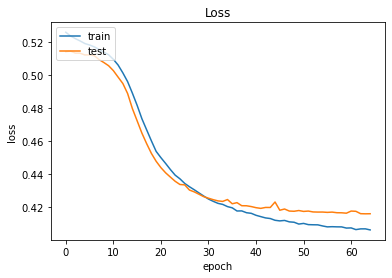

In [88]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [89]:
# getting users unrated movies
# HARD CODE USER ID FOR TEST
user_id = [20]
encoded_user_id = user_enc.transform(user_id)

rated = list(movie_merge[movie_merge['user_id'] == user_id[0]]['movie'])
print(rated)

[1270, 414, 1547, 1523, 36, 1329, 1407, 1234, 1365, 446, 1284, 1005, 27, 1657, 762, 1205, 1633, 987, 378, 456, 551, 1373, 1301, 797, 1102, 113, 1588, 463, 984, 199, 44, 747, 891, 1398, 690, 1210, 744, 225, 757, 142, 971, 1366, 1289, 598, 653, 794, 297, 1171]


In [90]:
# get unrated movies
unrated = [i for i in range(min(movie_merge['movie']), max(movie_merge['movie'])+1) if i not in rated]
# print(unrated)

In [91]:
len(rated) + len(unrated)

1664

In [92]:
### PREDICT RATINGS OF UNRATED MOVIES
model_input = [np.asarray(list(encoded_user_id)*len(unrated)), np.asarray(unrated)]
len(model_input), len(model_input[0])

predictions = model.predict(model_input)
predictions = np.max(predictions, axis=1)

sort_predictions = np.argsort(predictions)[::-1]

51/51 [==============================] - 0s 2ms/step


In [93]:
## extracting movies based on index
recommendations = item_enc.inverse_transform(sort_predictions)
recommendations

array(['Sabrina (1954)', 'Amityville: Dollhouse (1996)',
       'Breakdown (1997)', ...,
       "Robert A. Heinlein's The Puppet Masters (1994)",
       'Scarlet Letter, The (1995)', 'Wedding Gift, The (1994)'],
      dtype=object)

In [94]:
for i in recommendations[:10]:
    print(i)

Sabrina (1954)
Amityville: Dollhouse (1996)
Breakdown (1997)
Bogus (1996)
Baton Rouge (1988)
Sphere (1998)
Schizopolis (1996)
Suture (1993)
Surviving the Game (1994)
Eve's Bayou (1997)


In [95]:
# rating history
def rating_history(user_id, rating_range=None, N=None):
    user_ratings = movie_merge[movie_merge['user_id'] == user_id][['movie_title', 'rating']]
    
    if rating_range:
        lower_bound, upper_bound = rating_range
        user_ratings = user_ratings[(user_ratings['rating'] >= lower_bound) & (user_ratings['rating'] <= upper_bound)]
        
    # sort values
    user_ratings = user_ratings.sort_values(by='rating', ascending=False)
    user_ratings = user_ratings.head(N)
    
    if not user_ratings.empty:
        print(f'Rating history for User {user_id}:\n')
        for index, row in user_ratings.iterrows():
            print(f'{row["movie_title"]}, Rating: {row["rating"]}')
    else:
        print(f'\nUser {user_id} has no rating history.')
        
# rating_history(30, (4,5), 10)

## Evaluation Metrics

### MAE

In [96]:
# predicting rating on test set
y_pred = model.predict(X_test_array)

# convert probabilities into class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# MAE
mae = np.mean(np.abs(y_test - y_pred_labels))

print("MAE: ", mae)

313/313 [==============================] - 1s 2ms/step
MAE:  0.567


### Novelty

In [97]:
# NOVELTY
def novelty(recommended_items, item_popularity):
    novelty_score = np.sum(np.fromiter((-np.log2(item_popularity.get(item, 1.0)/ len(user_unique)) for item in recommended_items), dtype=float))
    novelty_score /= len(recommended_items)
    return novelty_score

In [98]:
# user_id = 22
N = 5 # 5 recommendations

novelty_scores = []

for user_id in user_unique:
    user_id = int(user_id)
    encoded_user_id = user_enc.transform([user_id])
    rated = list(movie_merge[movie_merge['user_id'] == user_id]['movie'])
    unrated = [i for i in range(min(movie_merge['movie']), max(movie_merge['movie'])+1) if i not in rated]

    # predictied unrated ratings
    model_input = [np.asarray(list(encoded_user_id)*len(unrated)), np.asarray(unrated)]
    predictions = model.predict(model_input)
    predictions = np.max(predictions, axis=1)
    sort_predictions = np.argsort(predictions)[::-1]

    # get movies based on index
    recommendations = item_enc.inverse_transform(sort_predictions)

#     print(recommendations[:N])
    # for novelty metric - calculate item pops to dictionary
    item_popularity = movie_merge[movie_merge['movie_title'].isin(recommendations[:N])]['movie_title'].value_counts().to_dict()


    # novelty score
    novelty_score = novelty(recommendations[:N], item_popularity)
    novelty_scores.append(novelty_score)
    
avg_novelty = sum(novelty_scores)/len(novelty_scores)    
print(f'Novelty Score: {avg_novelty}')

# print("\t")
# # print top N movies
# for i in recommendations[:N]:
#     print(i)

51/51 [==============================] - 0s 2ms/step


52/52 [==============================] - 0s 2ms/step


49/49 [==============================] - 0s 3ms/step


46/46 [==============================] - 0s 2ms/step


52/52 [==============================] - 0s 1ms/step


52/52 [==============================] - 0s 3ms/step


52/52 [==============================] - 0s 2ms/step
Novelty Score: 5.354887971907518


## CLI display/ recommender

In [99]:
## predicting movies based on user
def recommender(model):
    print("Welcome to the Movie Recommender System!")
    print("This recommender system helps you discover movies based on your preferences.")
    print("You can choose to explore recommendations as an existing user.")
    
    print("\t")
    user_id = input("Please enter your user ID: ")
    user_id = int(user_id)
    
    while True:
        # options
        print("\nChoose the following options:")
        print("1. Top recommended movies for you")
        print("2. View your rating history")
        print("3. Exit")
        option_choice = input("Enter your number (1-3): ")
        option_choice = int(option_choice)

        # top movies
        if option_choice == 1:
#             N = input("Enter the number of recommended movies: ")
            N = 5
            encoded_user_id = user_enc.transform([user_id])
            rated = list(movie_merge[movie_merge['user_id'] == user_id]['movie'])
            unrated = [i for i in range(min(movie_merge['movie']), max(movie_merge['movie'])+1) if i not in rated]

            # predictied unrated ratings
            model_input = [np.asarray(list(encoded_user_id)*len(unrated)), np.asarray(unrated)]
            predictions = model.predict(model_input)
            predictions = np.max(predictions, axis=1)
            sort_predictions = np.argsort(predictions)[::-1]

            # for novelty metric - calculate item pops to dictionary
            item_popularity = movie_merge['movie'].value_counts().to_dict()

            # get movies based on index
            recommendations = item_enc.inverse_transform(sort_predictions)

            print(f'\nTop 5 Movies Recommended for User {user_id}: ')
            # print top N movies
            for i in recommendations[:N]:
                print(i)

        elif option_choice == 2:
            N = input("Enter the number of movies: ")
            N = int(N)
            print("\t")

            # rating range
            print("Select your rating range: ")
            print("1. < 1")
            print("2. 1-3")
            print("3. 4-5")
            print("4. 5")
            range_choice = input("Enter your choice (1-4): \t")
            range_choice = int(range_choice)
            if range_choice == 1:
                rating_history(user_id, (0,1), N)

            elif range_choice == 2:
                rating_history(user_id, (1,3), N)

            elif range_choice == 3:
                rating_history(user_id, (4,5), N)

            elif range_choice == 4:
                rating_history(user_id, (5,5), N)
        
        else:
            print("Exiting. Goodbye.")
            break


In [100]:
recommender(model)

Welcome to the Movie Recommender System!
This recommender system helps you discover movies based on your preferences.
You can choose to explore recommendations as an existing user.
	
Please enter your user ID: 20

Choose the following options:
1. Top recommended movies for you
2. View your rating history
3. Exit
Enter your number (1-3): 1
51/51 [==============================] - 0s 2ms/step

Top 5 Movies Recommended for User 20: 
Sabrina (1954)
Amityville: Dollhouse (1996)
Breakdown (1997)
Bogus (1996)
Baton Rouge (1988)

Choose the following options:
1. Top recommended movies for you
2. View your rating history
3. Exit
Enter your number (1-3): 2
Enter the number of movies: 5
	
Select your rating range: 
1. < 1
2. 1-3
3. 4-5
4. 5
Enter your choice (1-4): 	4
Rating history for User 20:

It's a Wonderful Life (1946), Rating: 5.0
Braveheart (1995), Rating: 5.0
Searching for Bobby Fischer (1993), Rating: 5.0
Ghost and the Darkness, The (1996), Rating: 5.0

Choose the following options:
1. 